In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

In [27]:
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [28]:
print(df.shape)
print(df.columns)
df.head()

(50000, 2)
Index(['review', 'sentiment'], dtype='object')


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [29]:
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


showing how many “positive” and “negative” labels exist.

In [30]:
df['review_length']= df['review'].str.len()

In [31]:
df['review_words_length']= df['review'].str.split().str.len()
print(df[["review_length", "review_words_length"]].head())

   review_length  review_words_length
0           1761                  307
1            998                  162
2            926                  166
3            748                  138
4           1317                  230


The column review_length stores the number of characters in each review, and review_words_length stores the number of words in each review, both appended to the DataFrame.

In [32]:
# Check for any missing (NaN) values in 'review' or 'sentiment'
print(df["review"].isnull().any(), df["sentiment"].isnull().any())

# Check for any empty-string reviews
empty_count = (df["review"].str.strip() == "").sum()
print("Number of empty-string reviews:", empty_count)

False False
Number of empty-string reviews: 0


This means that there are no empty (null) reviews

In [33]:
html_mask= df['review'].str.contains(r"<br\s*/?>", regex=True)
print('Reviews with tags', html_mask.sum())
print(df[html_mask]['review'].head())

Reviews with tags 29200
0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object


This shows us the amount of reviews with tags, and gives an example of 5

In [34]:
df['clean_review']= df['review'].str.replace(r"<br\s*/?>", " ", regex=True)
print(df['clean_review'].str.contains(r"<br\s*/?>", regex=True).sum())
print(df['clean_review'].head(5))

0
0    One of the other reviewers has mentioned that ...
1    A wonderful little production.   The filming t...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: clean_review, dtype: object


This replaces the tags with a space, then checks to see how many reviews stil have tags (should be 0)

In [35]:
df['clean_review']= df['clean_review'].str.lower()

In [36]:
df["clean_review"] = (
    df["clean_review"]
    .str.replace(r"[^a-z0-9\s']", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

print(df["clean_review"].head(5))

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's love in the time of money is a...
Name: clean_review, dtype: object


In [37]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

df["clean_review"] = df["clean_review"].apply(remove_stopwords)
print(df['clean_review'].head(5))

0    reviewers mentioned watching just 1 oz episode...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there's family little boy jake think...
4    petter mattei's love time money visually stunn...
Name: clean_review, dtype: object


This removes stop words such as "the", "and", "in" e.t.c to reduce noise in the data

In [38]:
positive_review_list= df[df['sentiment']=='positive']['clean_review'].tolist()
negative_review_list=df[df['sentiment']=='positive']['clean_review'].tolist()
print(len('positive_review_list'), len('negative_review_list'))

20 20


In [39]:
positive_text= " ".join(positive_review_list)
negative_text= " ".join(negative_review_list)

In [40]:
from wordcloud import WordCloud
wc= WordCloud()
import matplotlib.pyplot as plt

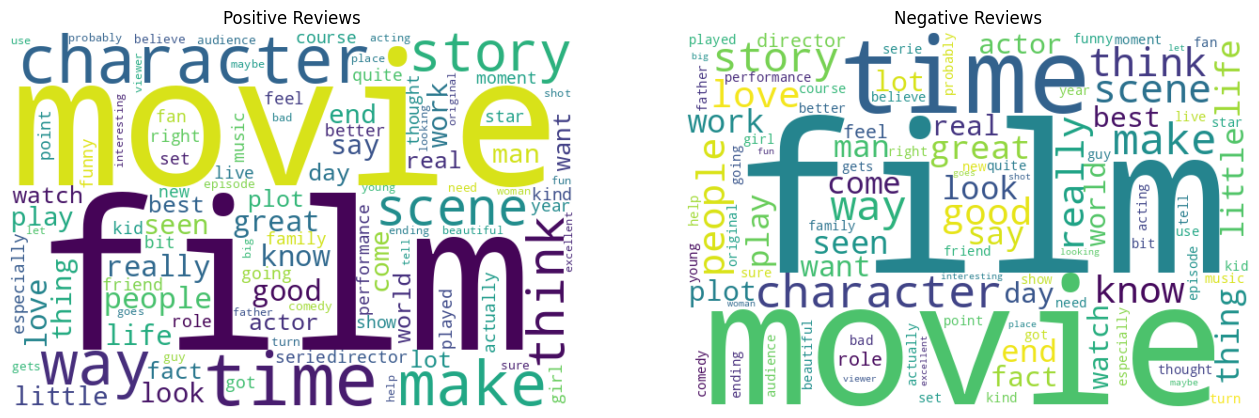

In [41]:
wc_pos = WordCloud(width=600, height=400, max_words=100, background_color="white").generate(positive_text)
wc_neg = WordCloud(width=600, height=400, max_words=100, background_color="white").generate(negative_text)
# 3. Plot side by side
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews")

plt.show()

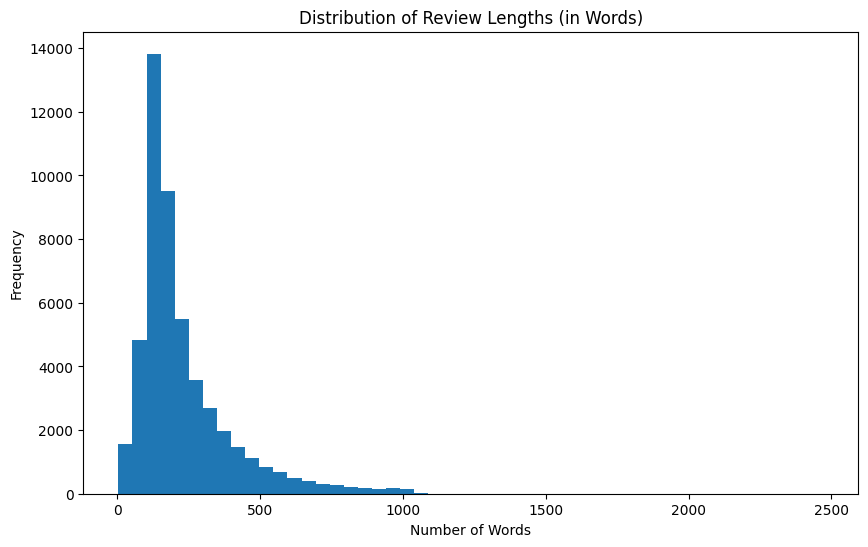

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["review_words_length"], bins=50)
plt.title("Distribution of Review Lengths (in Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [43]:
df['label']= df['sentiment'].map({"positive":1, "negative":0})

In [44]:
from sklearn.model_selection import train_test_split

# 1. Define features and target
X = df["clean_review"]
y = df["sentiment"]

# 2. First split: produce X_train_full (25k) and X_test (25k)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.50,     # 50% → 25k for test
    stratify=y,
    random_state=42
)

# 3. Second split: from X_train_full (25k), carve out X_train (20k) and X_val (5k)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.20,     # 20% of 25k → 5k for validation
    stratify=y_train_full,
    random_state=42
)

# 4. Verify sizes
print("Train set size:     ", len(X_train))   # ~20,000
print("Validation set size:", len(X_val))     # ~5,000
print("Test set size:      ", len(X_test))    # ~25,000

Train set size:      20000
Validation set size: 5000
Test set size:       25000



Split half the data for testing; from the other half, set aside 20% for validation. 
Validation lets us choose and tune models before evaluating on the final test set. 


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words="english"
)

# Fit on training data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform validation and test data
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Verify shapes
print("X_train_vec shape:", X_train_vec.shape)   # expected (20000, 10000)
print("X_val_vec shape:  ", X_val_vec.shape)    # expected (5000, 10000)
print("X_test_vec shape: ", X_test_vec.shape)   # expected (25000, 10000)=

X_train_vec shape: (20000, 10000)
X_val_vec shape:   (5000, 10000)
X_test_vec shape:  (25000, 10000)


In [46]:
from sklearn.linear_model import LogisticRegression

# 1. Instantiate the classifier
clf = LogisticRegression(
    C=1.0,
    solver="saga",
    max_iter=1000,
    n_jobs=-1
)

# 2. Fit on the training vectors and labels
clf.fit(X_train_vec, y_train)

# 3. (Optional) Check training accuracy
train_acc = clf.score(X_train_vec, y_train)
print(f"Training accuracy: {train_acc:.4f}")

Training accuracy: 0.9275


In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Predict labels on the test set
y_pred = clf.predict(X_test_vec)


# 3. Compute test‐set accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

# 4. Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

# 5. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Test accuracy: 0.8850

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88     12500
    positive       0.88      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Confusion Matrix:
 [[10906  1594]
 [ 1280 11220]]


In [48]:
print(y_pred[:10])  # first 10 test‐set predictions

['negative' 'negative' 'negative' 'negative' 'negative' 'positive'
 'negative' 'positive' 'negative' 'negative']
